In [8]:

import os, glob, json
import numpy as np
import rasterio
from rasterio.enums import Resampling
from rasterio.warp import reproject
import matplotlib.pyplot as plt


In [9]:
BASE_2020 = r"./DATA2020"
BASE_2024 = r"./DATA2024"
OUT_DIR   = r"./salidas_lab3"
os.makedirs(OUT_DIR, exist_ok=True)

def find_one(folder, patterns):
    for pat in patterns:
        hits = sorted(glob.glob(os.path.join(folder, pat)))
        if hits:
            return hits[0]
    return None

B04_2020 = find_one(BASE_2020, ["*B04*.tif", "*B04*.tiff", "*B04*.jp2"])
B08_2020 = find_one(BASE_2020, ["*B08*.tif", "*B08*.tiff", "*B08*.jp2"])
B04_2024 = find_one(BASE_2024, ["*B04*.tif", "*B04*.tiff", "*B04*.jp2"])
B08_2024 = find_one(BASE_2024, ["*B08*.tif", "*B08*.tiff", "*B08*.jp2"])

print("2020 B04:", B04_2020)
print("2020 B08:", B08_2020)
print("2024 B04:", B04_2024)
print("2024 B08:", B08_2024)

assert B04_2020 and B08_2020 and B04_2024 and B08_2024, "Falta alguna banda."


2020 B04: ./DATA2020\2020-Sentinel-2_L2A_B04.tiff
2020 B08: ./DATA2020\2020_Sentinel-2_L2A_B08.tiff
2024 B04: ./DATA2024\2024-_Sentinel-2_L2A_B04.tiff
2024 B08: ./DATA2024\2024_Sentinel-2_L2A_B08.tiff


In [10]:
def read_raster(path):
    with rasterio.open(path) as src:
        arr = src.read(1)
        prof = src.profile
    return arr, prof

def resample_to_template(src_arr, src_prof, template_prof, resampling=Resampling.bilinear):
    dst = np.empty((template_prof['height'], template_prof['width']), dtype=np.float32)
    reproject(
        source=src_arr, destination=dst,
        src_transform=src_prof['transform'], src_crs=src_prof['crs'],
        dst_transform=template_prof['transform'], dst_crs=template_prof['crs'],
        resampling=resampling
    )
    return dst

def compute_ndvi(nir, red, mask=None):
    nir = nir.astype(np.float32)
    red = red.astype(np.float32)
    den = nir + red
    ndvi = np.where(den == 0, np.nan, (nir - red) / den)
    if mask is not None:
        ndvi = np.where(mask, np.nan, ndvi)
    return ndvi

def save_tif(path, arr, prof_like):
    prof = prof_like.copy()
    prof.update(dtype=rasterio.float32, count=1, nodata=np.nan)
    with rasterio.open(path, "w", **prof) as dst:
        dst.write(arr.astype(np.float32), 1)


In [11]:
# 2024
red_2024, prof_2024 = read_raster(B04_2024)
nir_2024, _         = read_raster(B08_2024)
ndvi_2024 = compute_ndvi(nir_2024, red_2024)

# 2020 → remuestrear a la rejilla de 2024
red_2020, prof_2020 = read_raster(B04_2020)
nir_2020, _         = read_raster(B08_2020)

red_2020_rs = resample_to_template(red_2020, prof_2020, prof_2024, Resampling.bilinear)
nir_2020_rs = resample_to_template(nir_2020, prof_2020, prof_2024, Resampling.bilinear)

ndvi_2020 = compute_ndvi(nir_2020_rs, red_2020_rs)

# Guardar NDVI
save_tif(os.path.join(OUT_DIR, "ndvi_2020.tif"), ndvi_2020, prof_2024)
save_tif(os.path.join(OUT_DIR, "ndvi_2024.tif"), ndvi_2024, prof_2024)
print("NDVI 2020/2024 escritos en", OUT_DIR)


C:\Users\rodle\AppData\Local\Temp\ipykernel_27088\3468299419.py:21: RuntimeWarning: invalid value encountered in divide
  ndvi = np.where(den == 0, np.nan, (nir - red) / den)
C:\Users\rodle\AppData\Local\Temp\ipykernel_27088\3468299419.py:21: RuntimeWarning: invalid value encountered in divide
  ndvi = np.where(den == 0, np.nan, (nir - red) / den)


NDVI 2020/2024 escritos en ./salidas_lab3


In [12]:
diff = ndvi_2024 - ndvi_2020
save_tif(os.path.join(OUT_DIR, "ndvi_diff_24_minus_20.tif"), diff, prof_2024)

THRESH = -0.2  # ajusta si hace falta
deforest = np.where(np.isnan(diff), False, diff < THRESH).astype(np.uint8)
save_tif(os.path.join(OUT_DIR, "deforest_mask.tif"), deforest, prof_2024)

np.nanmin(diff), np.nanmax(diff), np.nanmean(diff)


(np.float32(-1.9160197), np.float32(1.9541422), np.float32(0.09519777))

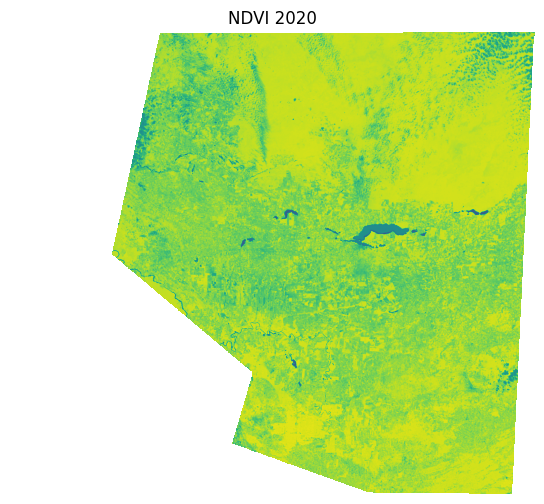

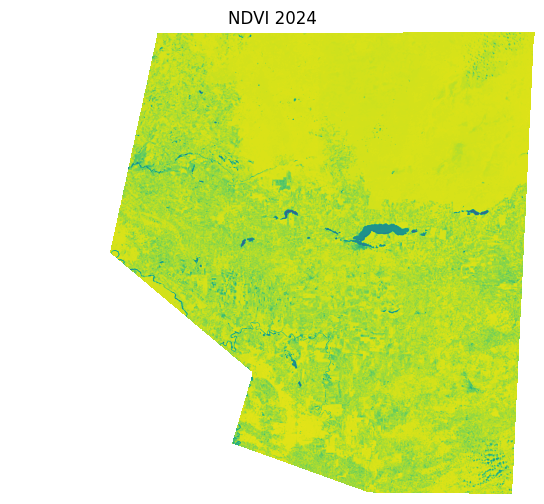

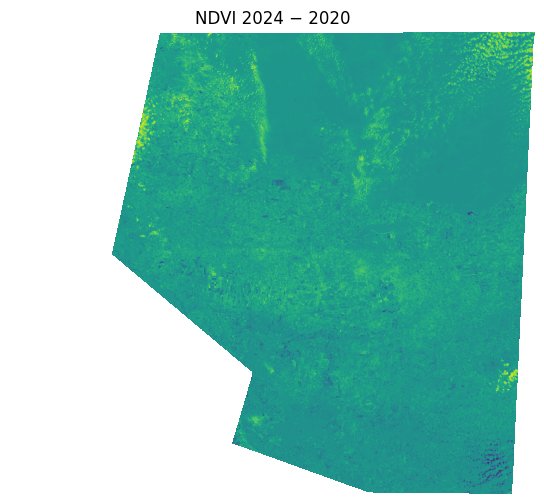

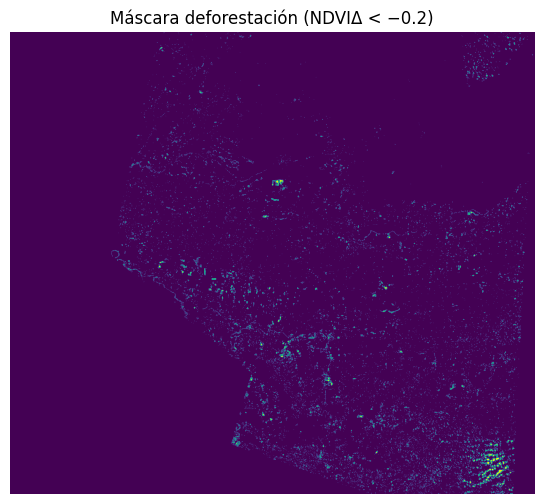

In [13]:
def show(arr, title, vmin=None, vmax=None, cmap=None):
    plt.figure(figsize=(7,6))
    plt.imshow(arr, vmin=vmin, vmax=vmax, cmap=cmap)
    plt.title(title); plt.axis("off"); plt.show()

show(ndvi_2020, "NDVI 2020", vmin=-1, vmax=1)
show(ndvi_2024, "NDVI 2024", vmin=-1, vmax=1)
show(diff, "NDVI 2024 − 2020", vmin=-1, vmax=1)
show(deforest, "Máscara deforestación (NDVIΔ < −0.2)")


Pixeles válidos: 3,596,447
Diff NDVI stats:
  p 0: -1.916
  p 1: -0.248
  p 5: -0.071
  p10: -0.010
  p25: 0.029
  p50: 0.065
  p75: 0.149
  p90: 0.255
  p95: 0.335
  p99: 0.591
  p100: 1.954
  min: -1.916 | max: 1.954


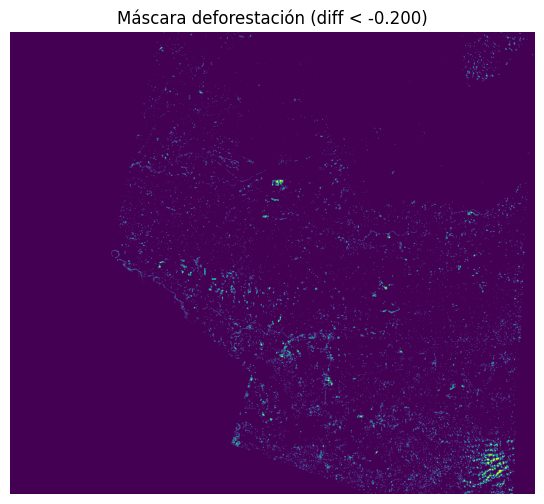

Área analizada: 0.00 ha
Pérdida (umbral -0.200): 0.00 ha
% deforestación: 1.48%


In [ ]:
import os, glob, rasterio
import numpy as np

# --- diferencia NDVI: pérdidas deben ser NEGATIVAS ---
diff = ndvi_2024 - ndvi_2020

valid_core = np.isfinite(ndvi_2020) & np.isfinite(ndvi_2024)

# Stats útiles del diff
valid_diff = diff[valid_core]
print(f"Pixeles válidos: {int(valid_core.sum()):,}")
if valid_core.sum() == 0:
    raise RuntimeError("No hay píxeles válidos tras filtrar NoData.")

print("Diff NDVI stats:")
for p in (0, 1, 5, 10, 25, 50, 75, 90, 95, 99, 100):
    try:
        print(f"  p{p:>2}: {np.nanpercentile(valid_diff, p):.3f}")
    except Exception:
        pass
print(f"  min: {np.nanmin(valid_diff):.3f} | max: {np.nanmax(valid_diff):.3f}")

# --- umbral (pérdida si diff < THRESH) ---
THRESH = -0.2
deforest_mask = (diff < THRESH) & valid_core

if deforest_mask.sum() == 0:
    auto_thresh = float(np.nanpercentile(valid_diff, 10))  
    print(f"[Aviso] Sin píxeles con THRESH={THRESH}. Usando p10={auto_thresh:.3f}")
    THRESH = auto_thresh
    deforest_mask = (diff < THRESH) & valid_core

ref_profile = None
for cand in [os.path.join(OUT_DIR, "NDVI_2024.tif"),
             os.path.join(OUT_DIR, "NDVI_2020.tif")]:
    if os.path.exists(cand):
        with rasterio.open(cand) as src:
            ref_profile = src.profile
        break
if ref_profile is None:
    pats = [
        os.path.join(".", "**", "*2024*B04*.tif*"),
        os.path.join(".", "**", "*B04*.tif*"),
    ]
    found = []
    for p in pats:
        found = glob.glob(p, recursive=True)
        if found:
            break
    if not found:
        raise FileNotFoundError("No encontré un GeoTIFF de referencia para obtener el profile.")
    with rasterio.open(found[0]) as src:
        ref_profile = src.profile

# --- guardar máscara usando ese profile ---
save_tif(os.path.join(OUT_DIR, "deforest_mask.tif"),
         deforest_mask.astype("float32"),
         ref_profile)

show(deforest_mask.astype(int),
     f"Máscara deforestación (diff < {THRESH:.3f})",
     vmin=0, vmax=1)

# --- hectáreas y porcentaje  ---
px_w = abs(ref_profile["transform"][0])
px_h = abs(ref_profile["transform"][4])
m2_per_pixel = px_w * px_h
ha_per_pixel = m2_per_pixel / 10_000.0

defor_pixels = int(deforest_mask.sum())
valid_pixels = int(valid_core.sum())

defor_ha = defor_pixels * ha_per_pixel
total_ha = valid_pixels * ha_per_pixel
defor_pct = (defor_ha / total_ha * 100) if total_ha > 0 else np.nan

print(f"Área analizada: {total_ha:,.2f} ha")
print(f"Pérdida (umbral {THRESH:.3f}): {defor_ha:,.2f} ha")
print(f"% deforestación: {defor_pct:.2f}%")
